# See classification

In [5]:
import pandas as pd

# === 檔案路徑 ===
TRAIN_PATH = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X1_all_logzscore_logzscore_with_y.tsv"
VAL_PATH   = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X2_all_logzscore_logzscore_with_y.tsv"

# === 讀取資料 ===
df_train = pd.read_csv(TRAIN_PATH, sep="\t")
df_val   = pd.read_csv(VAL_PATH, sep="\t")

# === 建立 binary 標籤 ===
df_train["gex_binary"] = (df_train["gex"] > 0.0).astype(int)
df_val["gex_binary"]   = (df_val["gex"] > 0.0).astype(int)

# === 統計數量與比例 ===
def summarize_binary(df, name):
    counts = df["gex_binary"].value_counts().sort_index()
    total = counts.sum()
    print(f"\n📊 {name} dataset summary")
    print(f"Total samples: {total}")
    print(f"Class 0 (gex == 0.0): {counts.get(0, 0)} ({counts.get(0, 0)/total:.2%})")
    print(f"Class 1 (gex > 0.0): {counts.get(1, 0)} ({counts.get(1, 0)/total:.2%})")

summarize_binary(df_train, "TRAIN (X1)")
summarize_binary(df_val, "VALID (X2)")



📊 TRAIN (X1) dataset summary
Total samples: 16284
Class 0 (gex == 0.0): 9448 (58.02%)
Class 1 (gex > 0.0): 6836 (41.98%)

📊 VALID (X2) dataset summary
Total samples: 16284
Class 0 (gex == 0.0): 8078 (49.61%)
Class 1 (gex > 0.0): 8206 (50.39%)


In [11]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  CONFIGURATION
# ============================================================
TRAIN_PATH = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X1_all_logzscore_logzscore_with_y.tsv"
VAL_PATH   = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X2_all_logzscore_logzscore_with_y.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]

# 🟩 改動：我們現在要分類 gex == 0.0 vs > 0.0
TARGET_COL = "gex_binary"

# Chromosomes (autosomes 2–22)
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

print("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    print(f"Fold {i+1}: {fset}")

# ============================================================
#                  DATA LOADING
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

# 🟩 新增：轉成二元分類標籤
df_train_full[TARGET_COL] = (df_train_full["gex"] > 0.0).astype(int)
df_val_full[TARGET_COL]   = (df_val_full["gex"] > 0.0).astype(int)

feature_cols = [c for c in df_train_full.columns if c not in META_COLS + [TARGET_COL]]
print(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  LIGHTGBM PARAMETERS (分類版)
# ============================================================
params = {
    "objective": "binary",        # 🟩 改成二分類
    "metric": ["auc", "binary_logloss"],
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": SEED,
    "deterministic": True,
    "force_row_wise": True,
}

# ============================================================
#                  CROSS-CHROMOSOME TRAINING
# ============================================================
results = []

for fold_idx, val_chrs in enumerate(folds):
    print(f"\n🚀 Fold {fold_idx+1} | Val chromosomes: {val_chrs}")
    
    # -----------------------------
    # Split by chromosome
    # -----------------------------
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    # -----------------------------
    # Prepare X, y
    # -----------------------------
    X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
    X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

    # -----------------------------
    # LightGBM Dataset
    # -----------------------------
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # -----------------------------
    # Train model
    # -----------------------------
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    # -----------------------------
    # Predictions
    # -----------------------------
    df_val["pred_prob"] = model.predict(X_val, num_iteration=model.best_iteration)
    df_val["pred_label"] = (df_val["pred_prob"] >= 0.4).astype(int)

    # -----------------------------
    # Evaluate Metrics
    # -----------------------------
    auc = roc_auc_score(y_val, df_val["pred_prob"])
    acc = accuracy_score(y_val, df_val["pred_label"])
    f1  = f1_score(y_val, df_val["pred_label"])
    cm  = confusion_matrix(y_val, df_val["pred_label"])

    print(f"\n📈 Fold {fold_idx+1} Results:")
    print(f"   AUC = {auc:.4f}, ACC = {acc:.4f}, F1 = {f1:.4f}")
    print(f"   Confusion matrix:\n{cm}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "auc": auc,
        "acc": acc,
        "f1": f1
    })

# ============================================================
#                  SUMMARY
# ============================================================
summary_fold = pd.DataFrame(results)
print("\n===== Cross-Chromosome Fold Summary =====")
print(summary_fold)
print(f"\nMean AUC: {summary_fold['auc'].mean():.4f}")
print(f"Mean ACC: {summary_fold['acc'].mean():.4f}")
print(f"Mean F1 : {summary_fold['f1'].mean():.4f}")


🔒 Global seed set to 42
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']
Feature count: 672

🚀 Fold 1 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.999979	train's binary_logloss: 0.0605642	val's auc: 0.911971	val's binary_logloss: 0.376432
Early stopping, best iteration is:
[125]	train's auc: 0.998679	train's binary_logloss: 0.111224	val's auc: 0.914974	val's binary_logloss: 0.370134

📈 Fold 1 Results:
   AUC = 0.9150, ACC = 0.8281, F1 = 0.8304
   Confusion matrix:
[[1890  490]
 [ 308 1953]]

🚀 Fold 2 | Val chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	train's auc: 0.992212	train's binary_log

# Apply classification with regression

## See different threshold in all features

🔒 Global seed set to 42
⚙️ Using all 2892 features (no FEATURES_PATH provided)
🧩 Chromosome folds:
  Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
  Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
  Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
  Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
  Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']

🚀 Fold 1 | Validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
🧠 Training Binary Classifier...
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.979745	val's auc: 0.919366
[400]	train's auc: 0.993532	val's auc: 0.921031
Early stopping, best iteration is:
[337]	train's auc: 0.990503	val's auc: 0.921309
📈 Binary Classifier: AUC=0.9213, ACC=0.8449, F1=0.8333
🧩 Training Regression Model...
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.109478	val's rmse: 0.166534
[400]	train's rmse: 0.0999039	val's rmse: 0.163488
Early stopping, best iteration is:
[439]	train's rmse: 0.09906	

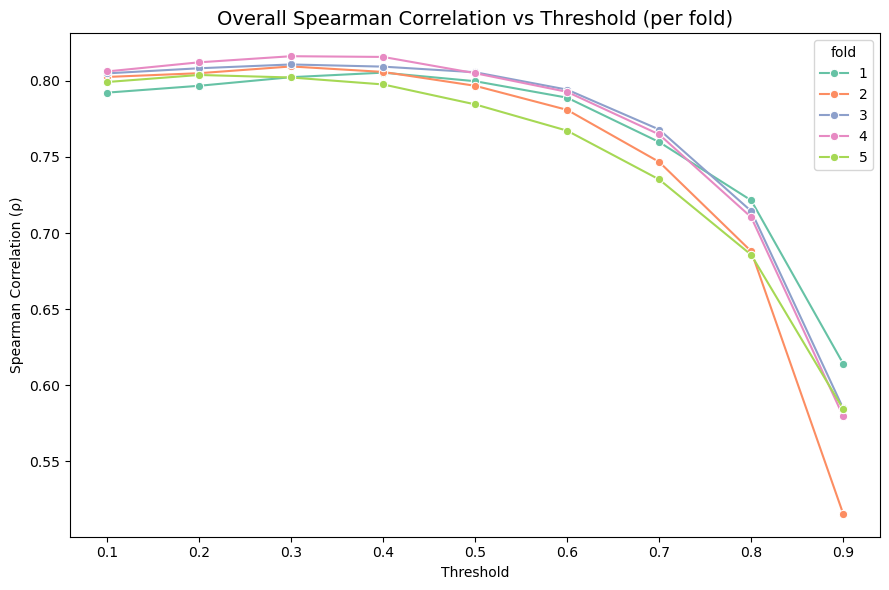

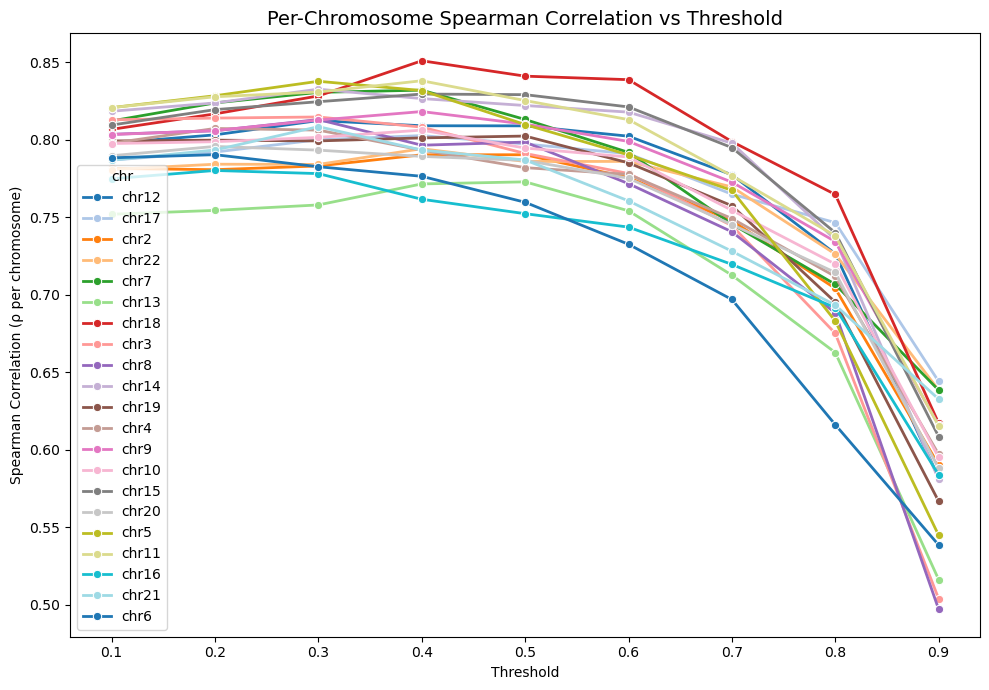

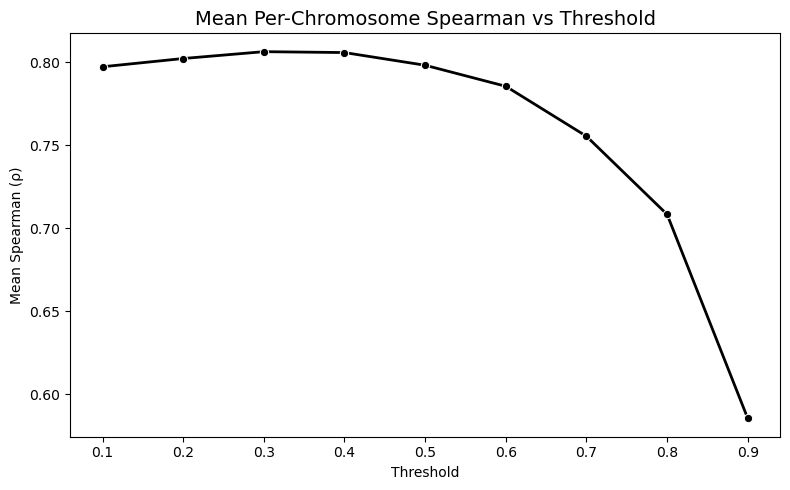


🌟 Best threshold = 0.30, mean per-chr ρ = 0.8063


In [ ]:
from scripts.classification import run_cross_chr_training

META_COLS = ["gene_name", "chr", "gene_start", "gene_end", "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]

run_cross_chr_training(
        train_path="../preprocessed_data/reference/1. merged data/with_y_100_one_side/X1_all_rank_features_with_y.tsv",
        val_path="../preprocessed_data/reference/1. merged data/with_y_100_one_side/X2_all_rank_features_with_y.tsv",
        meta_cols=META_COLS,
        features_path=None,  # ← 自動使用所有非 meta 欄位
    )

🔒 Global seed set to 42
⚙️ Using all 2892 features (no FEATURES_PATH provided)
🧩 Chromosome folds:
  Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
  Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
  Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
  Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
  Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']

🚀 Fold 1 | Validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
🧠 Training Binary Classifier...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	train's auc: 0.979022	val's auc: 0.935203
📈 Binary Classifier: AUC=0.9352, ACC=0.8599, F1=0.8336
🧩 Training Regression Model...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[389]	train's rmse: 0.101931	val's rmse: 0.148427
📈 Regression predictions: 0.7824429269678933

🚀 Fold 2 | Validation chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
🧠 Training Binary Classifier...
Training until validation s

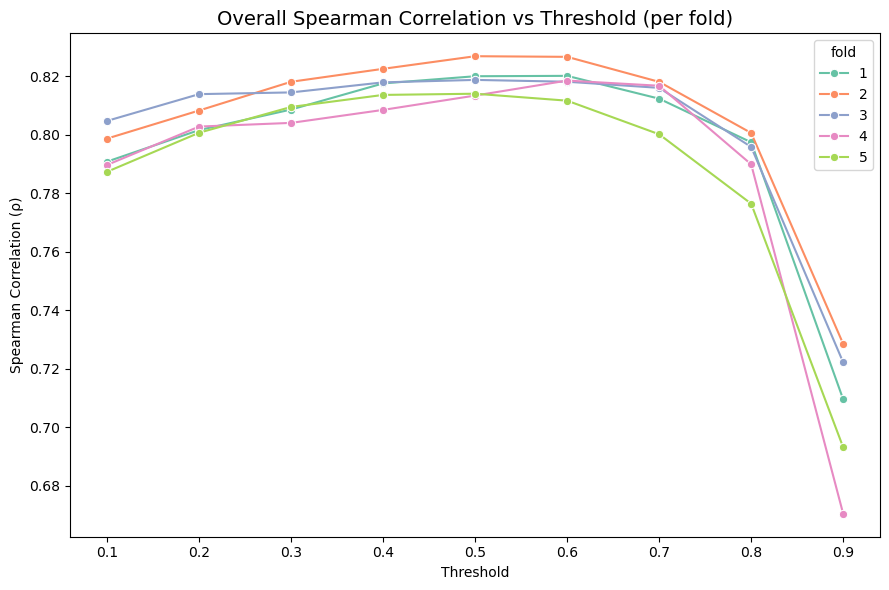

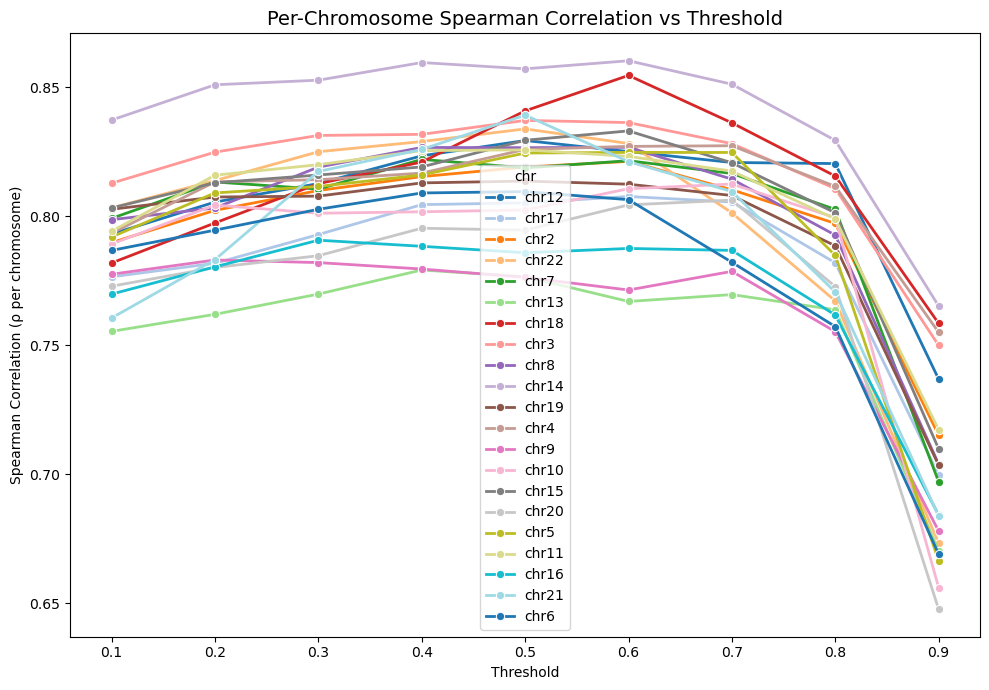

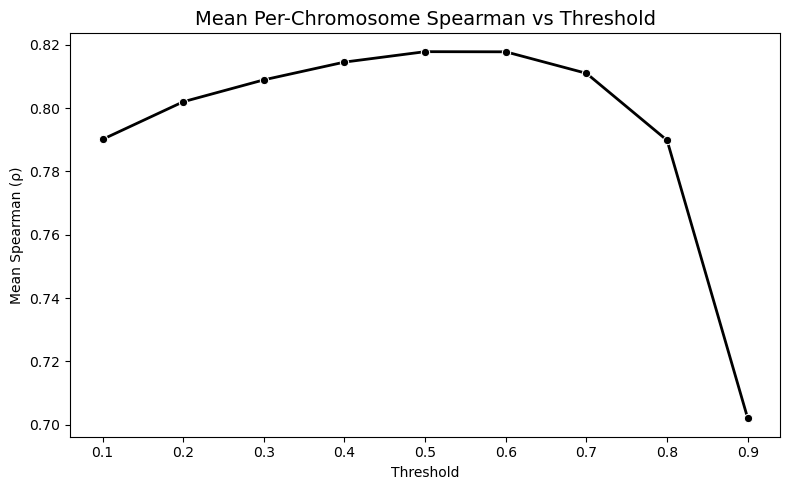


🌟 Best threshold = 0.50, mean per-chr ρ = 0.8178


(   fold       auc       acc        f1   rho_reg  rho_weighted
 0     1  0.935203  0.859944  0.833589  0.782443      0.783309
 1     2  0.937727  0.867139  0.844075  0.786544      0.789731
 2     3  0.934842  0.858963  0.840276  0.791770      0.792767
 3     4  0.926584  0.849170  0.820789  0.783619      0.783414
 4     5  0.934304  0.867378  0.837383  0.775946      0.778423,
    threshold   rho_chr
 0        0.1  0.790103
 1        0.2  0.801973
 2        0.3  0.808893
 3        0.4  0.814501
 4        0.5  0.817791
 5        0.6  0.817746
 6        0.7  0.810957
 7        0.8  0.789798
 8        0.9  0.702025)

In [2]:
from scripts.classification import run_cross_chr_training

META_COLS = ["gene_name", "chr", "gene_start", "gene_end", "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]

run_cross_chr_training(
        train_path="../preprocessed_data/reference/1. merged data/with_y_100_one_side/X2_all_rank_features_with_y.tsv",
        val_path="../preprocessed_data/reference/1. merged data/with_y_100_one_side/X1_all_rank_features_with_y.tsv",
        meta_cols=META_COLS,
        features_path=None,  # ← 自動使用所有非 meta 欄位
    )

## See different threshold in selected features from step 5.

🔒 Global seed set to 42
✅ Loaded 63 selected features from ../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features.tsv
🧩 Chromosome folds:
  Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
  Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
  Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
  Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
  Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']

🚀 Fold 1 | Validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
🧠 Training Binary Classifier...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	train's auc: 0.973855	val's auc: 0.923953
📈 Binary Classifier: AUC=0.9240, ACC=0.8526, F1=0.8429
🧩 Training Regression Model...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[336]	train's rmse: 0.11167	val's rmse: 0.16453
📈 Regression predictions: 0.7962868926807938

🚀 Fold 2 | Validation 

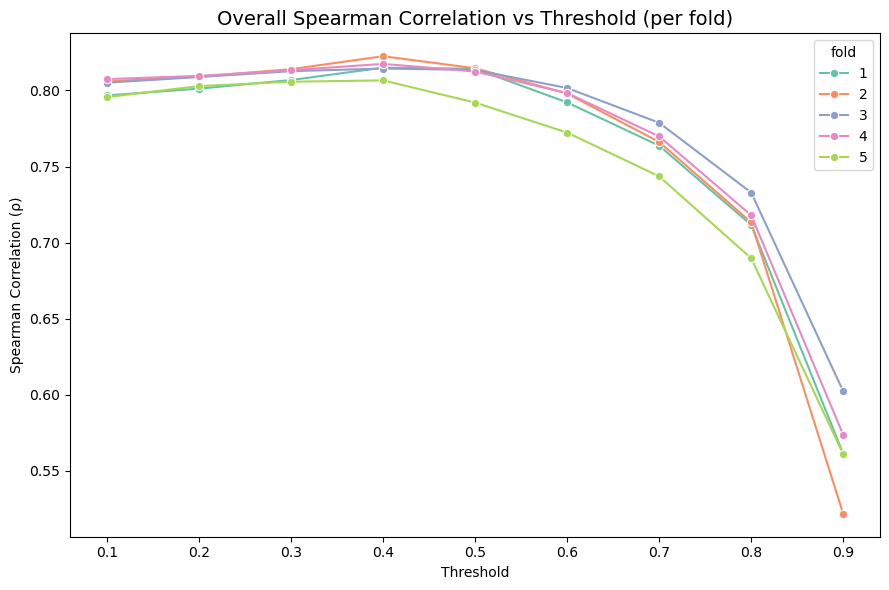

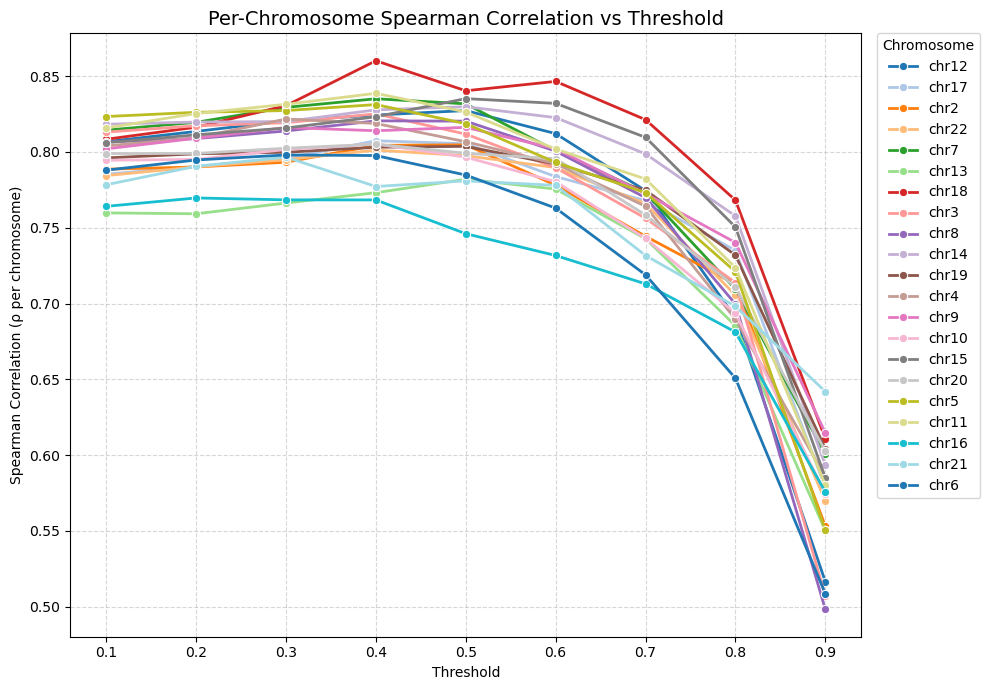

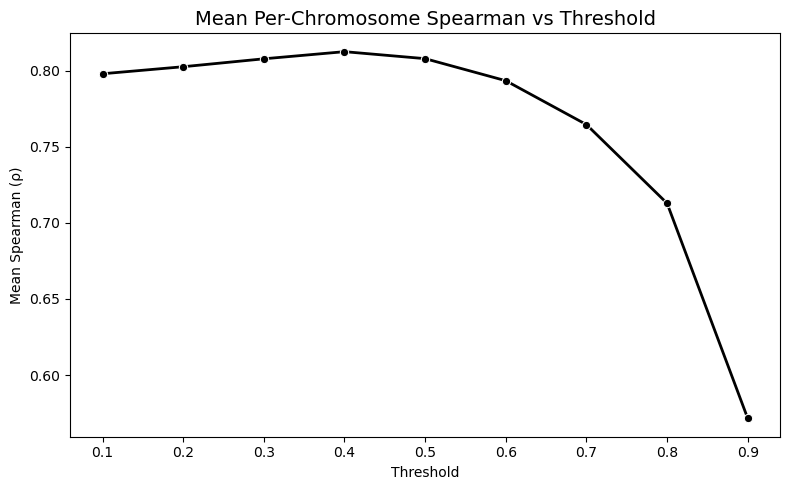


🌟 Best threshold = 0.40, mean per-chr ρ = 0.8125


In [3]:
from scripts.classification import run_cross_chr_training

META_COLS = ["gene_name", "chr", "gene_start", "gene_end", "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]

summary_1, chr_mean_1 = run_cross_chr_training(
        train_path="../preprocessed_data/reference/1. merged data/with_y_100_one_side/X1_all_rank_features_with_y.tsv",
        val_path="../preprocessed_data/reference/1. merged data/with_y_100_one_side/X2_all_rank_features_with_y.tsv",
        meta_cols=META_COLS,
        features_path = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features.tsv"
    )

🔒 Global seed set to 42
✅ Loaded 63 selected features from ../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features.tsv
🧩 Chromosome folds (train split only):
  Fold 1: ['chr10', 'chr15', 'chr2', 'chr4', 'chr9']
  Fold 2: ['chr11', 'chr16', 'chr20', 'chr5']
  Fold 3: ['chr12', 'chr17', 'chr21', 'chr6']
  Fold 4: ['chr13', 'chr18', 'chr22', 'chr7']
  Fold 5: ['chr14', 'chr19', 'chr3', 'chr8']

🚀 Fold 1 | Validation chromosomes: ['chr10', 'chr15', 'chr2', 'chr4', 'chr9']
📈 Binary Classifier: AUC=0.9432, ACC=0.8697, F1=0.8337
🧪 Applying model to TEST set ...
📊 Test Spearman: ρ_nomask=0.8032, ρ_masked=0.8125
📊 Val Spearman: ρ_nomask=0.7957, ρ_masked=0.8283

🚀 Fold 2 | Validation chromosomes: ['chr11', 'chr16', 'chr20', 'chr5']
📈 Binary Classifier: AUC=0.9408, ACC=0.8694, F1=0.8272
🧪 Applying model to TEST set ...
📊 Test Spearman: ρ_nomask=0.8016, ρ_masked=0.8058
📊 Val Spearman: ρ_nomask=0.7900, ρ_masked=0.8232

🚀 Fold 3 | 

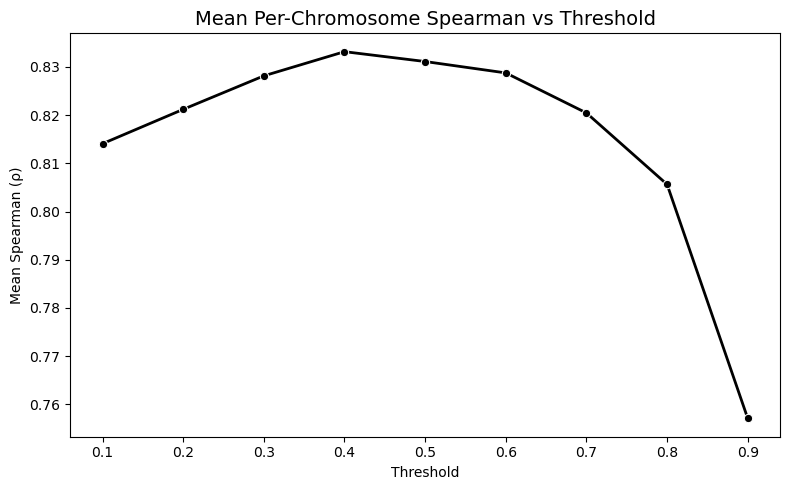


🌟 Best threshold = 0.40, mean per-chr ρ = 0.8332


In [5]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


# ============================================================
# FUNCTION: Cross-chromosome training (train split + test external)
# ============================================================
def run_cross_chr_training_with_test(
    train_path,
    test_path,
    meta_cols,
    features_path=None,
    target_rank="gex_rank",
    target_binary="gex_binary",
    seed=42,
    n_folds=5,
    thresholds=np.arange(0.1, 1.0, 0.1),
    params_bin=None,
    params_reg=None,
):
    """
    🧬 Cross-chromosome training pipeline
         - Use `train_path` for cross-chromosome CV (train/val)
         - Use `test_path` as an external test set for prediction

    Returns
    -------
    summary : pd.DataFrame
        Fold-wise model metrics (AUC, ACC, F1, rho_reg, rho_weighted)
    test_results : pd.DataFrame
        Spearman correlation on test set for each fold
    chr_mean : pd.DataFrame
        Mean per-chromosome Spearman correlation vs threshold
    """

    # ============================================================
    # SEED SETUP
    # ============================================================
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    print(f"🔒 Global seed set to {seed}")

    # ============================================================
    # LOAD DATA
    # ============================================================
    df_train_full = pd.read_csv(train_path, sep="\t")
    df_test_full  = pd.read_csv(test_path, sep="\t")

    # add binary target
    df_train_full[target_binary] = (df_train_full["gex"] > 0.0).astype(int)
    df_test_full[target_binary]  = (df_test_full["gex"] > 0.0).astype(int)

    # === Load features ===
    if features_path is not None and os.path.exists(features_path):
        feature_cols = pd.read_csv(features_path, sep="\t")["feature"].tolist()
        print(f"✅ Loaded {len(feature_cols)} selected features from {features_path}")
    else:
        feature_cols = [c for c in df_train_full.columns if c not in meta_cols + [target_binary]]
        print(f"⚙️ Using all {len(feature_cols)} features (no FEATURES_PATH provided)")

    # ============================================================
    # CHROMOSOME SPLITS (for training set)
    # ============================================================
    chromosomes = sorted(df_train_full["chr"].unique())
    folds = [chromosomes[i::n_folds] for i in range(n_folds)]
    print("🧩 Chromosome folds (train split only):")
    for i, fset in enumerate(folds):
        print(f"  Fold {i+1}: {fset}")

    # ============================================================
    # MODEL PARAMS (with default)
    # ============================================================
    default_params_bin = {
        "objective": "binary",
        "metric": ["auc"],
        "learning_rate": 0.016676974956976915,
        "num_leaves": 48,
        "max_depth": 8,
        "feature_fraction": 0.64561553423692,
        "bagging_fraction": 0.8113835038425429,
        "bagging_freq": 6,
        "lambda_l1": 0.3316673054635859,
        "lambda_l2": 0.8969317795206216,
        "min_gain_to_split": 0.04923442843722911,
        "min_data_in_leaf": 38,
        "verbose": -1,
        "seed": seed,
    }

    default_params_reg = {
        **default_params_bin,
        "objective": "regression",
        "metric": "rmse",
    }

    params_bin = params_bin or default_params_bin
    params_reg = params_reg or default_params_reg

    # ============================================================
    # RESULTS STORAGE
    # ============================================================
    results = []
    threshold_records = []
    chr_rho_records = []
    test_rho_records = []

    # ============================================================
    # CROSS-CHROMOSOME TRAINING LOOP (train split)
    # ============================================================
    for fold_idx, val_chrs in enumerate(folds):
        print(f"\n🚀 Fold {fold_idx+1} | Validation chromosomes: {val_chrs}")

        train_chrs = [c for c in chromosomes if c not in val_chrs]
        df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
        df_val   = df_train_full[df_train_full["chr"].isin(val_chrs)].copy()

        X_train, y_train_bin, y_train_reg = (
            df_train[feature_cols],
            df_train[target_binary],
            df_train[target_rank],
        )
        X_val, y_val_bin, y_val_reg = (
            df_val[feature_cols],
            df_val[target_binary],
            df_val[target_rank],
        )

        # === Binary Classifier ===
        dtrain_bin = lgb.Dataset(X_train, label=y_train_bin)
        dval_bin   = lgb.Dataset(X_val, label=y_val_bin, reference=dtrain_bin)
        model_bin = lgb.train(
            params_bin,
            dtrain_bin,
            valid_sets=[dtrain_bin, dval_bin],
            valid_names=["train", "val"],
            num_boost_round=2000,
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
        )

        df_val["pred_prob"] = model_bin.predict(X_val, num_iteration=model_bin.best_iteration)
        auc = roc_auc_score(y_val_bin, df_val["pred_prob"])
        acc = accuracy_score(y_val_bin, (df_val["pred_prob"] >= 0.5))
        f1  = f1_score(y_val_bin, (df_val["pred_prob"] >= 0.5))
        print(f"📈 Binary Classifier: AUC={auc:.4f}, ACC={acc:.4f}, F1={f1:.4f}")

        # === Regression Model ===
        dtrain_reg = lgb.Dataset(X_train, label=y_train_reg)
        dval_reg   = lgb.Dataset(X_val, label=y_val_reg, reference=dtrain_reg)
        model_reg = lgb.train(
            params_reg,
            dtrain_reg,
            valid_sets=[dtrain_reg, dval_reg],
            valid_names=["train", "val"],
            num_boost_round=2000,
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
        )

        df_val["pred_reg"] = model_reg.predict(X_val, num_iteration=model_reg.best_iteration)

        # === Baseline Comparisons ===
        rho_reg = spearmanr(df_val[target_rank], df_val["pred_reg"])[0]
        rho_weighted = spearmanr(df_val[target_rank], df_val["pred_reg"] * df_val["pred_prob"])[0]
        results.append({
            "fold": fold_idx + 1,
            "auc": auc,
            "acc": acc,
            "f1": f1,
            "rho_reg": rho_reg,
            "rho_weighted": rho_weighted,
        })

        # === Threshold Sweep ===
        for thr in thresholds:
            df_val["pred_masked_thr"] = df_val["pred_reg"] * (df_val["pred_prob"] >= thr).astype(int)
            rho_thr = spearmanr(df_val[target_rank], df_val["pred_masked_thr"])[0]
            threshold_records.append({"fold": fold_idx + 1, "threshold": thr, "rho": rho_thr})
            for chrom, subdf in df_val.groupby("chr"):
                if len(subdf) < 2:
                    continue
                rho_chr = spearmanr(subdf[target_rank], subdf["pred_masked_thr"])[0]
                chr_rho_records.append({
                    "fold": fold_idx + 1,
                    "chr": chrom,
                    "threshold": thr,
                    "rho_chr": rho_chr
                })

        # === Apply to Test Set ===
        print("🧪 Applying model to TEST set ...")
        X_test = df_test_full[feature_cols]
        y_test = df_test_full[target_rank]

        test_pred_prob = model_bin.predict(X_test, num_iteration=model_bin.best_iteration)
        test_pred_reg  = model_reg.predict(X_test, num_iteration=model_reg.best_iteration)

        rho_test_nomask = spearmanr(y_test, test_pred_reg)[0]
        rho_test_masked = spearmanr(y_test, test_pred_reg * (test_pred_prob >= 0.5).astype(int))[0]
        test_rho_records.append({
            "fold": fold_idx + 1,
            "rho_test_nomask": rho_test_nomask,
            "rho_test_masked": rho_test_masked
        })
        print(f"📊 Test Spearman: ρ_nomask={rho_test_nomask:.4f}, ρ_masked={rho_test_masked:.4f}")
        val_pred_prob = model_bin.predict(X_val, num_iteration=model_bin.best_iteration)
        val_pred_reg  = model_reg.predict(X_val, num_iteration=model_reg.best_iteration)

        rho_val_nomask = spearmanr(y_val_reg, val_pred_reg)[0]
        rho_val_masked = spearmanr(y_val_reg, val_pred_reg * (val_pred_prob >= 0.5).astype(int))[0]
        print(f"📊 Val Spearman: ρ_nomask={rho_val_nomask:.4f}, ρ_masked={rho_val_masked:.4f}")

    # ============================================================
    # SUMMARY
    # ============================================================
    summary = pd.DataFrame(results)
    thr_df = pd.DataFrame(threshold_records)
    chr_df = pd.DataFrame(chr_rho_records)
    test_results = pd.DataFrame(test_rho_records)
    chr_mean = chr_df.groupby("threshold", as_index=False)["rho_chr"].mean()

    print("\n===== Cross-Chromosome Summary (Train Split) =====")
    print(summary[["fold", "auc", "acc", "f1", "rho_reg", "rho_weighted"]])

    print("\n===== External Test Summary =====")
    print(test_results)

    # === Plot ===
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=chr_mean, x="threshold", y="rho_chr", marker="o", color="black", linewidth=2)
    plt.title("Mean Per-Chromosome Spearman vs Threshold", fontsize=14)
    plt.xlabel("Threshold")
    plt.ylabel("Mean Spearman (ρ)")
    plt.tight_layout()
    plt.show()

    best_thr = chr_mean.loc[chr_mean["rho_chr"].idxmax()]
    print(f"\n🌟 Best threshold = {best_thr['threshold']:.2f}, mean per-chr ρ = {best_thr['rho_chr']:.4f}")

    return summary, test_results, chr_mean


# ============================================================
# Example Call
# ============================================================
if __name__ == "__main__":
    META_COLS = [
        "gene_name", "chr", "gene_start", "gene_end",
        "TSS_start", "TSS_end", "strand", "gex", "gex_rank"
    ]

    run_cross_chr_training_with_test(
        train_path="../preprocessed_data/reference/1. merged data/with_y_100_one_side/X1_all_rank_features_with_y.tsv",
        test_path="../preprocessed_data/reference/1. merged data/with_y_100_one_side/X2_all_rank_features_with_y.tsv",
        meta_cols=META_COLS,
        features_path='../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features.tsv',
    )


In [121]:
import pandas as pd

# === 檔案路徑 ===
features_path = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features.tsv"
out_features_path = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features_new.tsv"

# === 讀取 feature 清單 ===
df_feat = pd.read_csv(features_path, sep="\t")

# === 確認欄位名稱 (通常是 "feature") ===
if "feature" not in df_feat.columns:
    raise ValueError(f"❌ 找不到 'feature' 欄位，實際欄位為: {df_feat.columns.tolist()}")

print(f"📥 讀入 {len(df_feat)} 個 features")

# === 過濾掉不需要的 mark ===
filtered_df = df_feat[~df_feat["feature"].str.startswith(("H3K4me3_gene_logz_min_me", "H3K27me3_gene_signal_diff_st", "H3K27me3_gene_width_entropy_st"))].reset_index(drop=True)

print(f"🧹 移除 H3K4me3_ / H3K27me3_ 開頭的 features，共移除 {len(df_feat) - len(filtered_df)} 個")
print(f"✅ 剩餘 features: {len(filtered_df)}")

# === 覆蓋存檔 ===
filtered_df.to_csv(out_features_path, sep="\t", index=False)
print(f"💾 已覆蓋儲存到原路徑：{out_features_path}")


📥 讀入 63 個 features
🧹 移除 H3K4me3_ / H3K27me3_ 開頭的 features，共移除 0 個
✅ 剩餘 features: 63
💾 已覆蓋儲存到原路徑：../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features_new.tsv


🔒 Global seed set to 42
✅ Loaded 45 selected features from ../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features_new.tsv
🧩 Chromosome folds:
  Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
  Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
  Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
  Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
  Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']

🚀 Fold 1 | Validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
🧠 Training Binary Classifier...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[337]	train's auc: 0.979425	val's auc: 0.918071
📈 Binary Classifier: AUC=0.9181, ACC=0.8446, F1=0.8378
🧩 Training Regression Model...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[333]	train's rmse: 0.114713	val's rmse: 0.173728
📈 Regression predictions: 0.778884603443495

🚀 Fold 2 | Valida

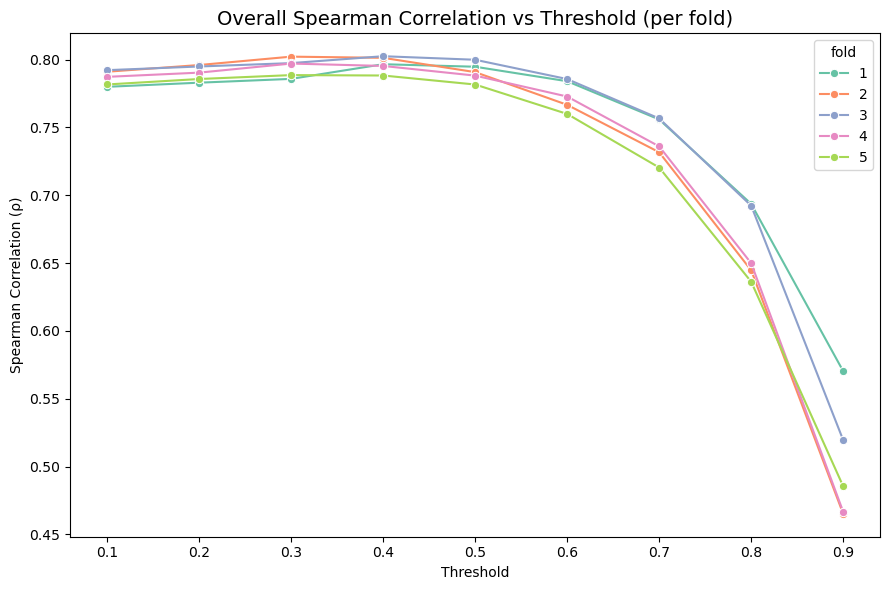

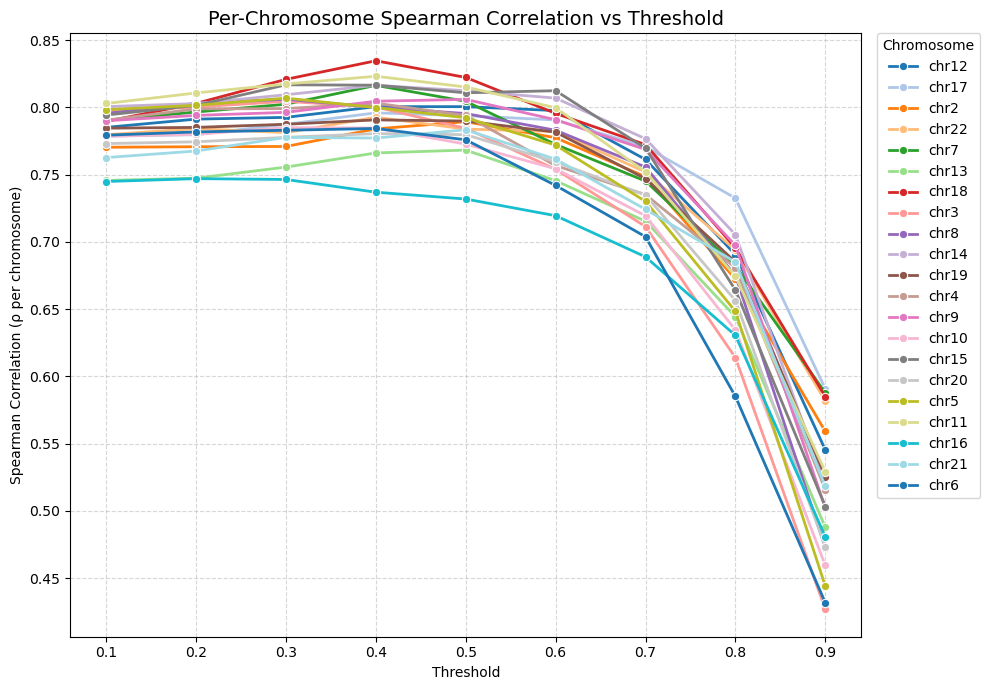

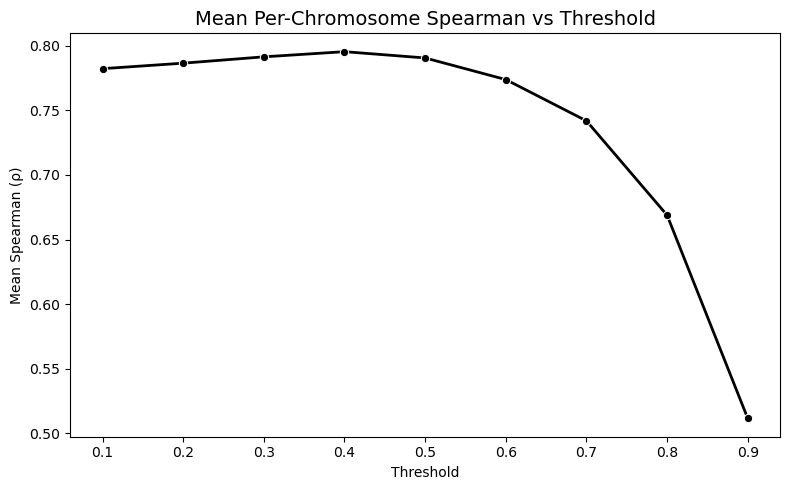


🌟 Best threshold = 0.40, mean per-chr ρ = 0.7956


In [119]:
from scripts.classification import run_cross_chr_training

META_COLS = ["gene_name", "chr", "gene_start", "gene_end", "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]

summary_1, chr_mean_1 = run_cross_chr_training(
        train_path="../preprocessed_data/reference/1. merged data/with_y_100_one_side/X1_all_rank_features_with_y.tsv",
        val_path="../preprocessed_data/reference/1. merged data/with_y_100_one_side/X2_all_rank_features_with_y.tsv",
        meta_cols=META_COLS,
        features_path = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features_new.tsv"
    )

🔒 Global seed set to 42
✅ Loaded 63 selected features from ../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features.tsv
🧩 Chromosome folds:
  Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
  Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
  Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
  Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
  Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']

🚀 Fold 1 | Validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
🧠 Training Binary Classifier...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[436]	train's auc: 0.986584	val's auc: 0.935689
📈 Binary Classifier: AUC=0.9357, ACC=0.8533, F1=0.8306
🧩 Training Regression Model...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[360]	train's rmse: 0.112905	val's rmse: 0.149231
📈 Regression predictions: 0.7817461784139064

🚀 Fold 2 | Validatio

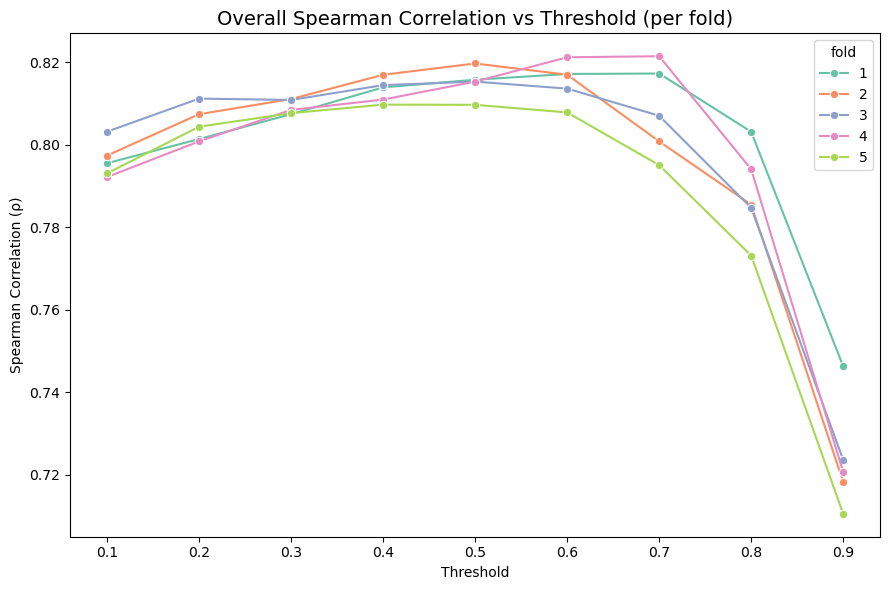

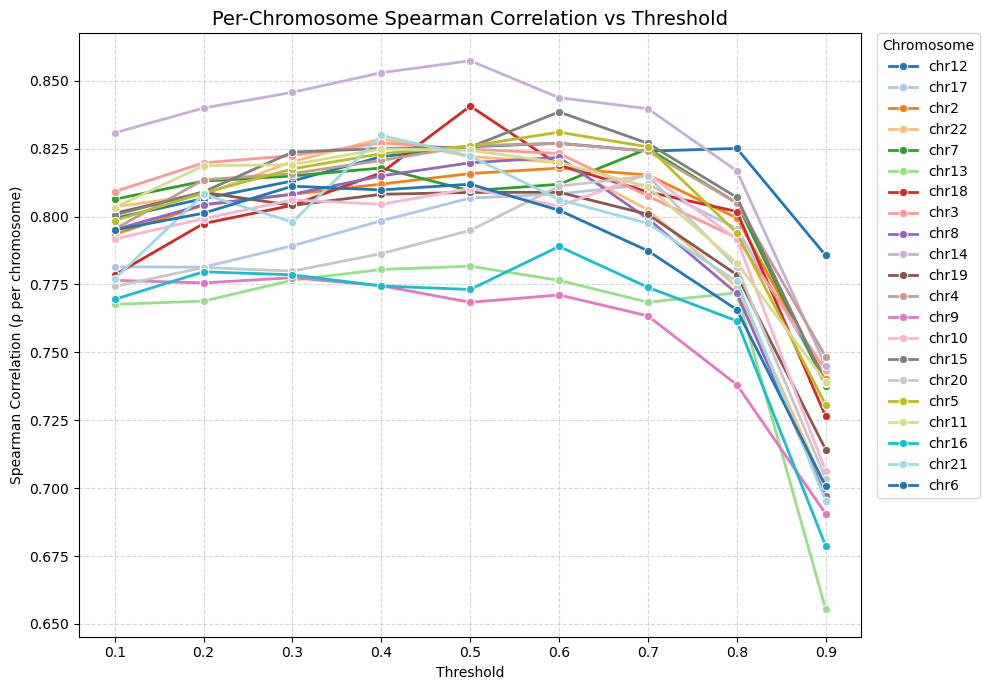

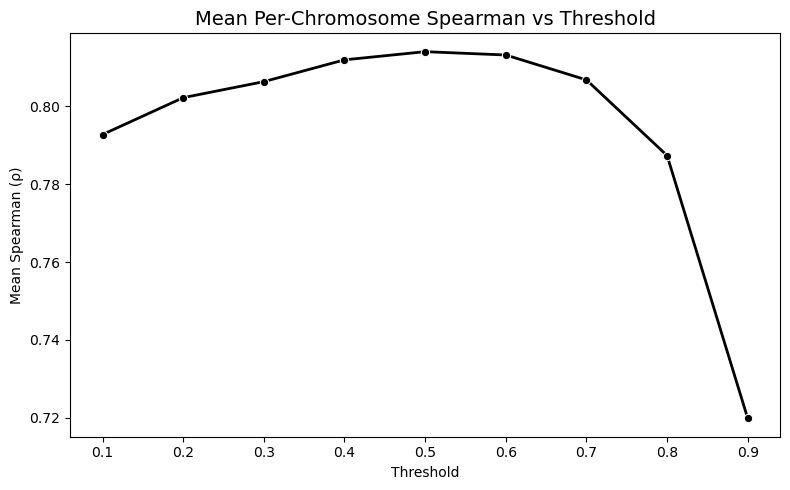


🌟 Best threshold = 0.50, mean per-chr ρ = 0.8141


In [4]:
from scripts.classification import run_cross_chr_training

META_COLS = ["gene_name", "chr", "gene_start", "gene_end", "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]

summary_2, chr_mean_2 = run_cross_chr_training(
        train_path="../preprocessed_data/reference/1. merged data/with_y_100_one_side/X2_all_rank_features_with_y.tsv",
        val_path="../preprocessed_data/reference/1. merged data/with_y_100_one_side/X1_all_rank_features_with_y.tsv",
        meta_cols=META_COLS,
        features_path = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features.tsv"
    )

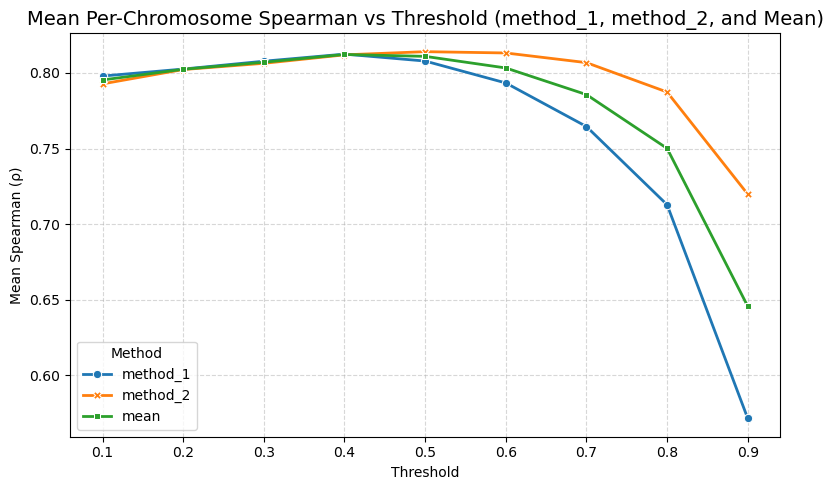

🌟 mean: best threshold = 0.40, mean ρ = 0.8122
🌟 method_1: best threshold = 0.40, mean ρ = 0.8125
🌟 method_2: best threshold = 0.50, mean ρ = 0.8141


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === 假設你已經有 chr_mean 和 chr_mean_2 ===
# 並且它們都有 'threshold' 與 'rho_chr' 欄位

chr_mean_1["method"] = "method_1"
chr_mean_2["method"] = "method_2"

# === 合併兩個 DataFrame ===
chr_mean_combined = pd.concat([chr_mean_1, chr_mean_2], ignore_index=True)

# === 新增 mean 曲線 ===
chr_mean_avg = (
    chr_mean_1.merge(chr_mean_2, on="threshold", suffixes=("_1", "_2"))
)
chr_mean_avg["rho_chr"] = chr_mean_avg[["rho_chr_1", "rho_chr_2"]].mean(axis=1)
chr_mean_avg["method"] = "mean"

# === 合併所有結果 ===
chr_mean_all = pd.concat([chr_mean_combined, chr_mean_avg[["threshold", "rho_chr", "method"]]], ignore_index=True)

# === 畫圖 ===
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=chr_mean_all,
    x="threshold",
    y="rho_chr",
    hue="method",
    style="method",
    markers=True,
    dashes=False,
    linewidth=2,
)

plt.title("Mean Per-Chromosome Spearman vs Threshold (method_1, method_2, and Mean)", fontsize=14)
plt.xlabel("Threshold")
plt.ylabel("Mean Spearman (ρ)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Method", loc="best")
plt.tight_layout()
plt.show()

# === 找出三者各自最佳 threshold ===
for method_name, df_method in chr_mean_all.groupby("method"):
    best_row = df_method.loc[df_method["rho_chr"].idxmax()]
    print(f"🌟 {method_name}: best threshold = {best_row['threshold']:.2f}, mean ρ = {best_row['rho_chr']:.4f}")


# See different strategy to combine threshold from different folds

In [26]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import KFold

# ============================================================
# GLOBAL CONFIG
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

TRAIN_PATH = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X1_all_logzscore_logzscore_with_y.tsv"
VAL_PATH   = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X2_all_logzscore_logzscore_with_y.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_RANK = "gex_rank"
TARGET_BINARY = "gex_binary"

chromosomes = [f"chr{i}" for i in range(2, 23)]
N_INNER_FOLDS = 5
MASK_THRESHOLD = 0.4

# ============================================================
# LOAD DATA
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

df_train_full[TARGET_BINARY] = (df_train_full["gex"] > 0.0).astype(int)
df_val_full[TARGET_BINARY]   = (df_val_full["gex"] > 0.0).astype(int)

feature_cols = [c for c in df_train_full.columns if c not in META_COLS + [TARGET_BINARY]]
print(f"Feature count: {len(feature_cols)}")

# ============================================================
# MODEL PARAMS
# ============================================================
params_bin = {
    "objective": "binary",
    "metric": ["auc"],
    "learning_rate": 0.0167,
    "num_leaves": 48,
    "max_depth": 8,
    "feature_fraction": 0.65,
    "bagging_fraction": 0.81,
    "bagging_freq": 6,
    "lambda_l1": 0.33,
    "lambda_l2": 0.89,
    "min_data_in_leaf": 38,
    "verbose": -1,
    "seed": SEED,
}

params_reg = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.0167,
    "num_leaves": 48,
    "max_depth": 8,
    "feature_fraction": 0.65,
    "bagging_fraction": 0.81,
    "bagging_freq": 6,
    "lambda_l1": 0.33,
    "lambda_l2": 0.89,
    "min_data_in_leaf": 38,
    "verbose": -1,
    "seed": SEED,
}

# ============================================================
# MAIN LOOP: LEAVE-ONE-CHROMOSOME
# ============================================================
results = []

for val_chr in chromosomes:
    print(f"\n🚀 Leave-one-chromosome: {val_chr}")

    # Split outer folds
    df_train = df_train_full[df_train_full["chr"] != val_chr].copy()
    df_test  = df_val_full[df_val_full["chr"] == val_chr].copy()

    # Containers for inner folds
    preds_reg = []
    preds_prob = []

    # --- Inner chromosome folds ---
    inner_chrs = [c for c in chromosomes if c != val_chr]
    kf = KFold(n_splits=N_INNER_FOLDS, shuffle=True, random_state=SEED)

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(inner_chrs)):
        inner_train_chrs = [inner_chrs[i] for i in train_idx]
        inner_val_chrs   = [inner_chrs[i] for i in val_idx]

        df_inner_train = df_train[df_train["chr"].isin(inner_train_chrs)]
        df_inner_val   = df_train[df_train["chr"].isin(inner_val_chrs)]

        # --- Prepare data ---
        X_train, y_train_bin, y_train_reg = (
            df_inner_train[feature_cols],
            df_inner_train[TARGET_BINARY],
            df_inner_train[TARGET_RANK],
        )
        X_val, y_val_bin, y_val_reg = (
            df_inner_val[feature_cols],
            df_inner_val[TARGET_BINARY],
            df_inner_val[TARGET_RANK],
        )


        # --- Train binary model ---
        dtrain_bin = lgb.Dataset(X_train, label=y_train_bin)
        dval_bin   = lgb.Dataset(X_val, label=y_val_bin, reference=dtrain_bin)

        model_bin = lgb.train(
                params_bin,
                dtrain_bin,
                valid_sets=[dtrain_bin, dval_bin],
                valid_names=["train", "val"],
                num_boost_round=2000,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=100),
                    lgb.log_evaluation(period=200)
                ],
            )
        # --- Train regression model ---

        dtrain_reg = lgb.Dataset(X_train, label=y_train_reg)
        dval_reg   = lgb.Dataset(X_val, label=y_val_reg, reference=dtrain_reg)
        model_reg = lgb.train(
            params_reg,
            dtrain_reg,
            valid_sets=[dtrain_reg, dval_reg],
            valid_names=["train", "val"],
            num_boost_round=2000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=200)
            ],
        )
        # --- Predict on held-out test chromosome ---
        X_test = df_test[feature_cols]
        preds_prob.append(model_bin.predict(X_test))
        preds_reg.append(model_reg.predict(X_test))

    # Stack predictions
    preds_prob = np.array(preds_prob)
    preds_reg = np.array(preds_reg)

    # --- Combine methods ---
    mean_prob = preds_prob.mean(axis=0)
    mean_reg = preds_reg.mean(axis=0)

    # 1️⃣ Mean-mask
    mask_mean = (mean_prob >= MASK_THRESHOLD).astype(int)
    pred_mean_masked = mean_reg * mask_mean

    # 2️⃣ All-mask
    mask_all = np.prod((preds_prob >= MASK_THRESHOLD).astype(int), axis=0)
    pred_all_masked = mean_reg * mask_all

    # 3️⃣ No-mask
    pred_nomask = mean_reg

    # --- Evaluate Spearman ---
    rho_mean = spearmanr(df_test[TARGET_RANK], pred_mean_masked)[0]
    rho_all  = spearmanr(df_test[TARGET_RANK], pred_all_masked)[0]
    rho_none = spearmanr(df_test[TARGET_RANK], pred_nomask)[0]

    results.append({
        "chr": val_chr,
        "rho_mean": rho_mean,
        "rho_all": rho_all,
        "rho_none": rho_none,
    })

    print(f"   Mean-mask ρ={rho_mean:.4f} | All-mask ρ={rho_all:.4f} | No-mask ρ={rho_none:.4f}")

# ============================================================
# SUMMARY
# ============================================================
results_df = pd.DataFrame(results)
print("\n===== Per-Chromosome Results =====")
print(results_df)

print(f"\nAverage ρ (Mean-mask): {results_df['rho_mean'].mean():.4f}")
print(f"Average ρ (All-mask):  {results_df['rho_all'].mean():.4f}")
print(f"Average ρ (No-mask):   {results_df['rho_none'].mean():.4f}")


🔒 Global seed set to 42
Feature count: 672

🚀 Leave-one-chromosome: chr2
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.972382	val's auc: 0.941536
[400]	train's auc: 0.987575	val's auc: 0.942219
Early stopping, best iteration is:
[324]	train's auc: 0.982653	val's auc: 0.942421
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.118122	val's rmse: 0.136855
[400]	train's rmse: 0.10378	val's rmse: 0.135344
Early stopping, best iteration is:
[454]	train's rmse: 0.10039	val's rmse: 0.135225
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.973399	val's auc: 0.942326
Early stopping, best iteration is:
[288]	train's auc: 0.981653	val's auc: 0.943036
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.116282	val's rmse: 0.141325
[400]	train's rmse: 0.101599	val's rmse: 0.140043
[600]	train's rmse: 0.089481	val's rmse: 0.139835
Early stopping, best iteration is:
[

In [5]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import KFold

# ============================================================
# GLOBAL CONFIG
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

TRAIN_PATH = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/X1_all_rank_features_with_y.tsv"
VAL_PATH   = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/X2_all_rank_features_with_y.tsv"
FEATURES_PATH = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_RANK = "gex_rank"
TARGET_BINARY = "gex_binary"

chromosomes = [f"chr{i}" for i in range(2, 23)]
N_INNER_FOLDS = 5
MASK_THRESHOLD = 0.4

# ============================================================
# LOAD DATA
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

if FEATURES_PATH is not None:
    selected_features = pd.read_csv(FEATURES_PATH, sep="\t")["feature"].tolist()
    feature_cols = [c for c in selected_features if c not in META_COLS]
    print(f"🔑 Loaded {len(feature_cols)} selected features from {FEATURES_PATH}")
else:
    feature_cols = [c for c in df_train_full.columns if c not in META_COLS]

df_train_full[TARGET_BINARY] = (df_train_full["gex"] > 0.0).astype(int)
df_val_full[TARGET_BINARY]   = (df_val_full["gex"] > 0.0).astype(int)

print(f"Feature count: {len(feature_cols)}")

# ============================================================
# MODEL PARAMS
# ============================================================
params_bin = {
    "objective": "binary",
    "metric": ["auc"],
    "learning_rate": 0.016676974956976915,
    "num_leaves": 48,
    "max_depth": 8,
    "feature_fraction": 0.64561553423692,
    "bagging_fraction": 0.8113835038425429,
    "bagging_freq": 6,
    "lambda_l1": 0.3316673054635859,
    "lambda_l2": 0.8969317795206216,
    "min_gain_to_split": 0.04923442843722911,
    "min_data_in_leaf": 38,
    "verbose": -1,
    "seed": SEED,
}

params_reg = params_bin.copy()
params_reg.update({"objective": "regression", "metric": "rmse"})

# ============================================================
# MAIN LOOP: LEAVE-ONE-CHROMOSOME
# ============================================================
results_summary = []   # 平均 per chromosome
results_inner = []     # 詳細每個 inner fold

for val_chr in chromosomes:
    print(f"\n🚀 Leave-one-chromosome: {val_chr}")

    # Split outer folds
    df_train = df_train_full[df_train_full["chr"] != val_chr].copy()
    df_test  = df_val_full[df_val_full["chr"] == val_chr].copy()

    inner_chrs = [c for c in chromosomes if c != val_chr]
    kf = KFold(n_splits=N_INNER_FOLDS, shuffle=True, random_state=SEED)

    preds_reg_folds = []
    preds_prob_folds = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(inner_chrs)):
        inner_train_chrs = [inner_chrs[i] for i in train_idx]
        inner_val_chrs   = [inner_chrs[i] for i in val_idx]

        df_inner_train = df_train[df_train["chr"].isin(inner_train_chrs)]
        df_inner_val   = df_train[df_train["chr"].isin(inner_val_chrs)]

        # Prepare data
        X_train, y_train_bin, y_train_reg = (
            df_inner_train[feature_cols],
            df_inner_train[TARGET_BINARY],
            df_inner_train[TARGET_RANK],
        )
        X_val, y_val_bin, y_val_reg = (
            df_inner_val[feature_cols],
            df_inner_val[TARGET_BINARY],
            df_inner_val[TARGET_RANK],
        )

        # Binary model
        dtrain_bin = lgb.Dataset(X_train, label=y_train_bin)
        dval_bin   = lgb.Dataset(X_val, label=y_val_bin, reference=dtrain_bin)
        model_bin = lgb.train(
            params_bin,
            dtrain_bin,
            valid_sets=[dtrain_bin, dval_bin],
            num_boost_round=2000,
            callbacks=[lgb.early_stopping(stopping_rounds=200)],
        )

        # Regression model
        dtrain_reg = lgb.Dataset(X_train, label=y_train_reg)
        dval_reg   = lgb.Dataset(X_val, label=y_val_reg, reference=dtrain_reg)
        model_reg = lgb.train(
            params_reg,
            dtrain_reg,
            valid_sets=[dtrain_reg, dval_reg],
            num_boost_round=2000,
            callbacks=[lgb.early_stopping(stopping_rounds=200)],
        )

        # Predict on test chromosome
        X_test = df_test[feature_cols]
        pred_prob = model_bin.predict(X_test)
        pred_reg  = model_reg.predict(X_test)

        preds_prob_folds.append(pred_prob)
        preds_reg_folds.append(pred_reg)

        # Evaluate per fold
        rho_fold = spearmanr(df_test[TARGET_RANK], pred_reg)[0]
        # 安全地抓 AUC 分數（如果不存在就回 NaN）
        auc_train = model_bin.best_score.get("train", {}).get("auc", np.nan)
        auc_val   = model_bin.best_score.get("val", {}).get("auc", np.nan)

        results_inner.append({
            "outer_chr": val_chr,
            "inner_fold": fold_idx + 1,
            "rho_reg": rho_fold,
            "mean_pred": np.mean(pred_reg),
            "auc_train_bin": auc_train,
            "auc_val_bin": auc_val
        })  
        print(f"   Inner Fold {fold_idx+1} → ρ_reg={rho_fold:.4f}")

    # Stack inner predictions
    preds_prob_folds = np.array(preds_prob_folds)
    preds_reg_folds = np.array(preds_reg_folds)

    mean_prob = preds_prob_folds.mean(axis=0)
    mean_reg = preds_reg_folds.mean(axis=0)

      # ============================================================
    # Combine masking strategies
    # ============================================================
    mask_mean = (mean_prob >= MASK_THRESHOLD).astype(int)
    pred_mean_masked = mean_reg * mask_mean

    mask_all = np.prod((preds_prob_folds >= MASK_THRESHOLD).astype(int), axis=0)
    pred_all_masked = mean_reg * mask_all

    mask_union = np.max((preds_prob_folds >= MASK_THRESHOLD).astype(int), axis=0)
    pred_union_masked = mean_reg * mask_union

    # 🧠 Soft / Fractional masking (average mask weight across folds)
    soft_mask = np.mean((preds_prob_folds >= MASK_THRESHOLD).astype(float), axis=0)
    pred_inter3 = mean_reg * soft_mask

    pred_nomask = mean_reg

    # ============================================================
    # Evaluate aggregated predictions
    # ============================================================
    rho_mean  = spearmanr(df_test[TARGET_RANK], pred_mean_masked)[0]
    rho_all   = spearmanr(df_test[TARGET_RANK], pred_all_masked)[0]
    rho_union = spearmanr(df_test[TARGET_RANK], pred_union_masked)[0]
    rho_soft  = spearmanr(df_test[TARGET_RANK], pred_inter3)[0]
    rho_none  = spearmanr(df_test[TARGET_RANK], pred_nomask)[0]

    results_summary.append({
        "chr": val_chr,
        "rho_mean":  rho_mean,
        "rho_all":   rho_all,
        "rho_union": rho_union,
        "rho_soft":  rho_soft,
        "rho_none":  rho_none,
    })

    print(
        f"📊 {val_chr} → "
        f"Mean-mask ρ={rho_mean:.4f} | "
        f"All-mask ρ={rho_all:.4f} | "
        f"Union-mask ρ={rho_union:.4f} | "
        f"Soft-mask ρ={rho_soft:.4f} | "
        f"No-mask ρ={rho_none:.4f}"
    )

# ============================================================
# SUMMARY
# ============================================================
results_df = pd.DataFrame(results_summary)
results_inner_df = pd.DataFrame(results_inner)

print("\n===== Per-Chromosome Summary =====")
print(results_df)

print(f"\nAverage ρ (Mean-mask):  {results_df['rho_mean'].mean():.4f}")
print(f"Average ρ (All-mask):   {results_df['rho_all'].mean():.4f}")
print(f"Average ρ (Union-mask): {results_df['rho_union'].mean():.4f}")
print(f"Average ρ (Soft-mask):  {results_df['rho_soft'].mean():.4f}")
print(f"Average ρ (No-mask):    {results_df['rho_none'].mean():.4f}")

print("\n===== Inner Fold Detail (first few rows) =====")
print(results_inner_df.head())

# # Optional: save both
results_df.to_csv("results_summary_per_chr.tsv", sep="\t", index=False)
# results_inner_df.to_csv("results_inner_folds.tsv", sep="\t", index=False)
print("\n💾 Saved detailed results → results_inner_folds.tsv")


🔒 Global seed set to 42
🔑 Loaded 63 selected features from ../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features.tsv
Feature count: 63

🚀 Leave-one-chromosome: chr2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[393]	training's auc: 0.983724	valid_1's auc: 0.944988
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[500]	training's rmse: 0.110975	valid_1's rmse: 0.131529
   Inner Fold 1 → ρ_reg=0.7908
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[454]	training's auc: 0.988415	valid_1's auc: 0.950024
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[654]	training's rmse: 0.110356	valid_1's rmse: 0.132447
   Inner Fold 2 → ρ_reg=0.7895
Training until validation scores don't improve for 200 rounds
Early stopping, best iterati

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_6508/3873169229.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_df, x="Method", y="Spearman_ρ", palette="Set2")


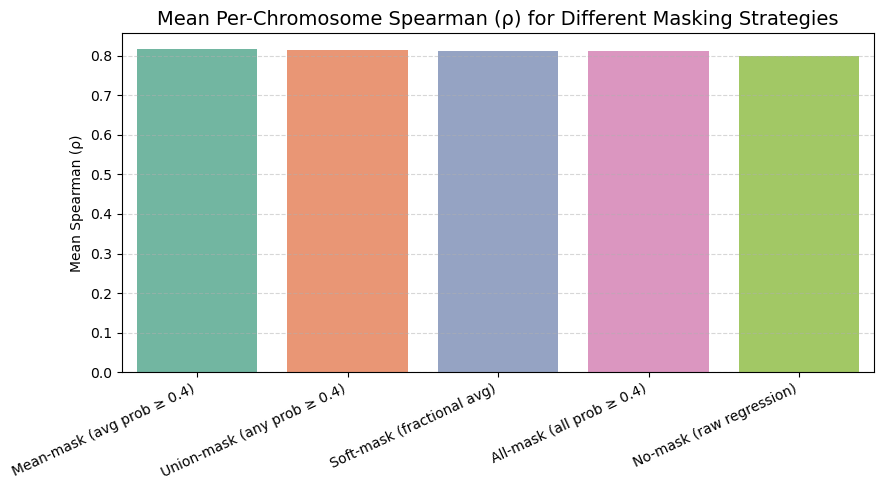

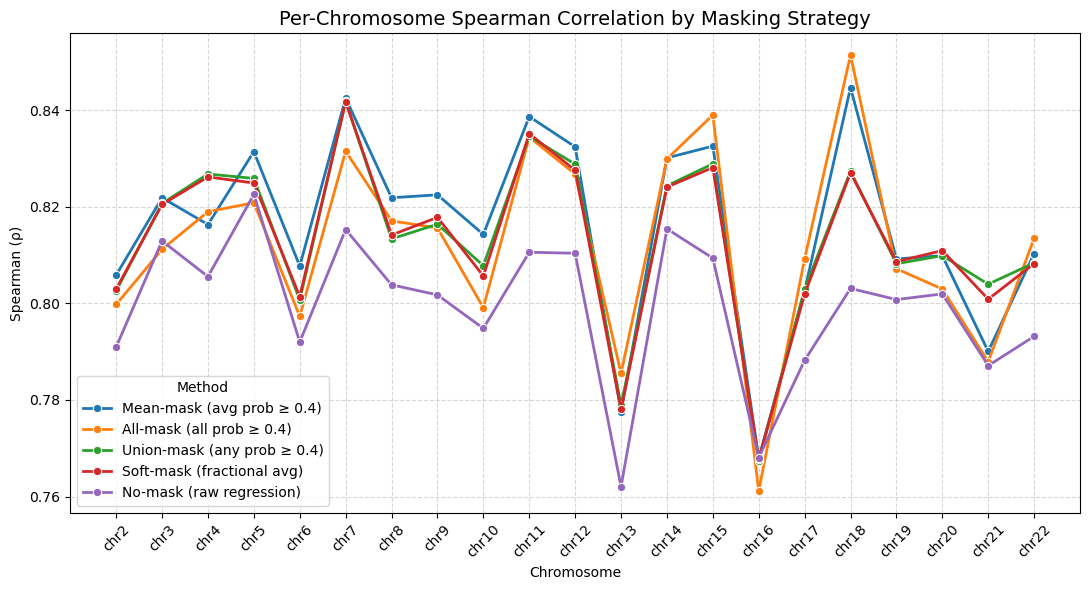


🌟 Best method = Mean-mask (avg prob ≥ 0.4) with mean Spearman ρ = 0.8157


In [ ]:
# ============================================================
# 📊 Visualization: Mean per-chromosome Spearman (5 Mask Methods)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- Melt results for plotting ---
plot_df = results_df.melt(
    id_vars="chr",
    value_vars=["rho_mean", "rho_all", "rho_union", "rho_soft", "rho_none", "rho_mean_prob"],
    var_name="Method",
    value_name="Spearman_ρ"
)

# --- Rename methods for clearer legend ---
plot_df["Method"] = plot_df["Method"].replace({
    "rho_mean": "Mean-mask (avg prob ≥ 0.4)",
    "rho_all": "All-mask (all prob ≥ 0.4)",
    "rho_union": "Union-mask (any prob ≥ 0.4)",
    "rho_soft": "Soft-mask (fractional avg)",
    "rho_none": "No-mask (raw regression)",
    "rho_mean_prob": "Mean-mask (using mean mask * mean prob)",
})

# --- Calculate mean per method ---
mean_df = plot_df.groupby("Method", as_index=False)["Spearman_ρ"].mean().sort_values("Spearman_ρ", ascending=False)

# --- 🎨 Bar plot of mean correlation per method ---
plt.figure(figsize=(9, 5))
sns.barplot(data=mean_df, x="Method", y="Spearman_ρ", palette="Set2")
plt.title("Mean Per-Chromosome Spearman (ρ) for Different Masking Strategies", fontsize=14)
plt.ylabel("Mean Spearman (ρ)")
plt.xlabel("")
plt.xticks(rotation=25, ha="right")
plt.grid(True, linestyle="--", alpha=0.5, axis="y")
plt.tight_layout()
plt.show()

# ============================================================
# 📈 Line plot: Per-chromosome trend comparison
# ============================================================
plt.figure(figsize=(11, 6))
sns.lineplot(data=plot_df, x="chr", y="Spearman_ρ", hue="Method", marker="o", linewidth=2)
plt.title("Per-Chromosome Spearman Correlation by Masking Strategy", fontsize=14)
plt.xlabel("Chromosome")
plt.ylabel("Spearman (ρ)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ============================================================
# 🌟 Print best performing method
# ============================================================
best_method = mean_df.loc[mean_df["Spearman_ρ"].idxmax()]
print(f"\n🌟 Best method = {best_method['Method']} with mean Spearman ρ = {best_method['Spearman_ρ']:.4f}")


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_88141/3834962453.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_df, x="Method", y="Spearman_ρ", palette="Set2")


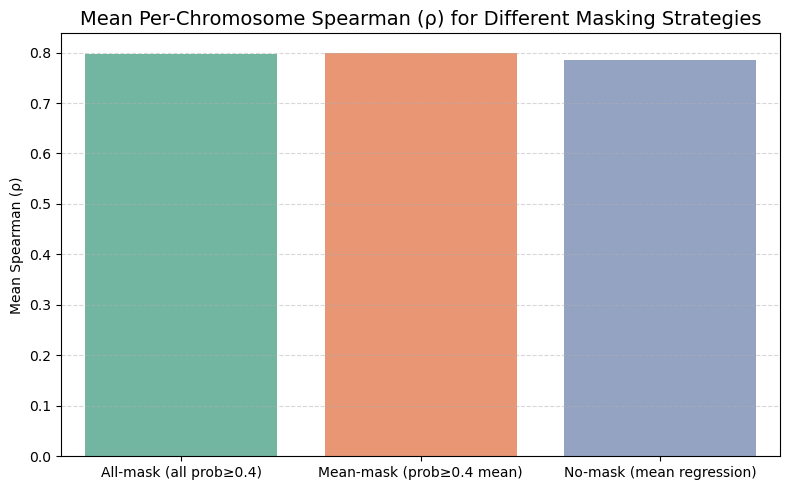

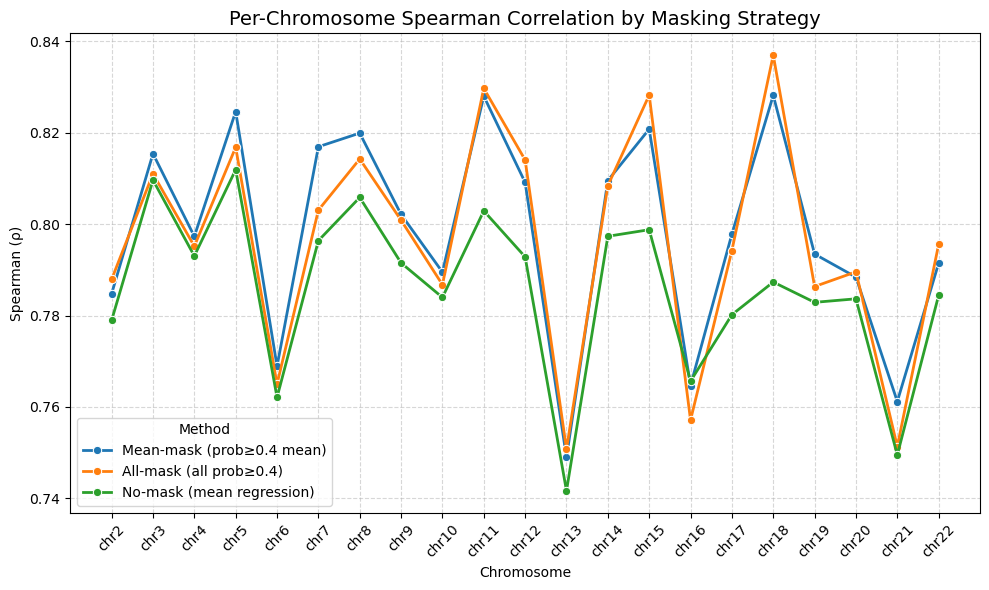


🌟 Best method = Mean-mask (prob≥0.4 mean) with mean Spearman ρ = 0.7981


In [ ]:
# ============================================================
# 📊 Visualization: Mean per-chromosome Spearman (3 Mask Methods)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- Melt results for plotting ---
plot_df = results_df.melt(id_vars="chr",
                          value_vars=["rho_mean", "rho_all", "rho_none"],
                          var_name="Method",
                          value_name="Spearman_ρ")

# --- Rename methods for clearer legend ---
plot_df["Method"] = plot_df["Method"].replace({
    "rho_mean": "Mean-mask (prob≥0.4 mean)",
    "rho_all": "All-mask (all prob≥0.4)",
    "rho_none": "No-mask (mean regression)"
})

# --- Calculate mean per method ---
mean_df = plot_df.groupby("Method", as_index=False)["Spearman_ρ"].mean()

# --- Draw line/bar plot ---
plt.figure(figsize=(8, 5))
sns.barplot(data=mean_df, x="Method", y="Spearman_ρ", palette="Set2")
plt.title("Mean Per-Chromosome Spearman (ρ) for Different Masking Strategies", fontsize=14)
plt.ylabel("Mean Spearman (ρ)")
plt.xlabel("")
plt.grid(True, linestyle="--", alpha=0.5, axis="y")
plt.tight_layout()
plt.show()

# ============================================================
# 📈 Optional: per-chromosome trend line
# ============================================================
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df, x="chr", y="Spearman_ρ", hue="Method", marker="o", linewidth=2)
plt.title("Per-Chromosome Spearman Correlation by Masking Strategy", fontsize=14)
plt.xlabel("Chromosome")
plt.ylabel("Spearman (ρ)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- Print best performing method ---
best_method = mean_df.loc[mean_df["Spearman_ρ"].idxmax()]
print(f"\n🌟 Best method = {best_method['Method']} with mean Spearman ρ = {best_method['Spearman_ρ']:.4f}")


# See why so chr is hard and some or easy

In [145]:
import pandas as pd
import numpy as np
import os

# === 設定檔案路徑 ===
data_dir = "../preprocessed_data/reference/1. merged data/without_y_100_one_side/"
cells = ["X1", "X2", "X3"]

meta_cols = [
    "gene_name", "chr", "gene_start", "gene_end",
    "TSS_start", "TSS_end", "strand", "gex", "gex_rank"
]

import pandas as pd
import numpy as np
import os

# === 設定檔案路徑 ===
data_dir = "../preprocessed_data/reference/1. merged data/without_y_100_one_side/"
cells = ["X1", "X2", "X3"]

meta_cols = [
    "gene_name", "chr", "gene_start", "gene_end",
    "TSS_start", "TSS_end", "strand", "gex", "gex_rank"
]

dfs = []

# === 逐 cell 讀取並計算每條 chr 的 summary ===
for cell in cells:
    path = os.path.join(data_dir, f"{cell}_all_logzscore_logzscore.tsv")
    print(f"📂 Loading {cell} ...")
    df = pd.read_csv(path, sep="\t")
    print(df.shape)
    feature_cols = [c for c in df.columns if c not in meta_cols and df[c].dtype != 'object']

    df_chr = (
        df.groupby("chr")[feature_cols]
          .agg(["mean", "std"])
          .reset_index()
    )

    # 攤平 multi-index 欄位名稱
    df_chr.columns = ["chr"] + [f"{col}_{stat}" for col, stat in df_chr.columns[1:]]
    df_chr["cell"] = cell
    dfs.append(df_chr)

# === 合併三個 cell ===
df_chr_all = pd.concat(dfs, ignore_index=True)
df_chr_cell = df_chr_all.copy()  # ✅ 要從合併後的資料複製

# === 對 chr across cells 取平均 ===
numeric_cols = df_chr_all.select_dtypes(include=[np.number]).columns.tolist()
chr_df = (
    df_chr_all[["chr"] + numeric_cols]
    .groupby("chr", as_index=False)
    .agg(np.mean)
)

print(f"✅ chr_df created with {len(chr_df)} chromosomes, shape = {chr_df.shape}")
print(f"✅ df_chr_cell created with {len(df_chr_cell)} rows (cell info preserved)")


📂 Loading X1 ...
📂 Loading X2 ...
📂 Loading X3 ...
✅ chr_df created with 22 chromosomes, shape = (22, 1345)
✅ df_chr_cell created with 66 rows (cell info preserved)


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_6508/814351421.py:57: FutureWarning: The provided callable <function mean at 0x104c79580> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(np.mean)


In [6]:
import pandas as pd
import numpy as np
import os

# === 設定檔案路徑 ===
data_dir = "../preprocessed_data/reference/1. merged data/without_y_100_one_side/"
cells = ["X1", "X2", "X3"]

meta_cols = [
    "gene_name", "chr", "gene_start", "gene_end",
    "TSS_start", "TSS_end", "strand", "gex", "gex_rank"
]

# === 讀取 feature 清單 ===
features_path = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features.tsv"
df_feat = pd.read_csv(features_path, sep="\t")

if "feature" not in df_feat.columns:
    raise ValueError(f"❌ 找不到 'feature' 欄位，實際欄位有: {df_feat.columns.tolist()}")

selected_features = df_feat["feature"].tolist()
print(f"🔑 Loaded {len(selected_features)} selected features")

dfs = []

# === 逐 cell 讀取並計算每條 chr 的 summary ===
for cell in cells:
    path = os.path.join(data_dir, f"{cell}_all_rank_features.tsv")
    if not os.path.exists(path):
        print(f"⚠️ Missing file for {cell}: {path}")
        continue

    print(f"📂 Loading {cell} ...")
    df = pd.read_csv(path, sep="\t")

    # ✅ 確保所有 feature 都存在
    feature_cols = [f for f in selected_features if f in df.columns]
    missing = set(selected_features) - set(feature_cols)
    if missing:
        print(f"⚠️ {len(missing)} features not found in {cell}: {list(missing)[:5]}...")

    # === 每個 cell 各自計算 chr-level summary ===
    df_chr = (
        df.groupby("chr")[feature_cols]
          .agg(["mean", "std"])
          .reset_index()
    )

    # 攤平成單層欄名
    df_chr.columns = ["chr"] + [f"{col}_{stat}" for col, stat in df_chr.columns[1:]]
    df_chr["cell"] = cell

    dfs.append(df_chr)

# === 合併所有 cell ===
df_chr_cell = pd.concat(dfs, ignore_index=True)
print(f"✅ df_chr_cell created: {df_chr_cell.shape} (每列 = 一個 cell × 染色體)")

# === 再從 df_chr_cell 建出跨 cell 平均版本 ===
numeric_cols = df_chr_cell.select_dtypes(include=[np.number]).columns.tolist()
chr_df = (
    df_chr_cell.groupby("chr", as_index=False)[numeric_cols]
    .mean()
)
print(f"✅ chr_df created: {chr_df.shape} (跨 cell 平均)")



🔑 Loaded 63 selected features
📂 Loading X1 ...
📂 Loading X2 ...
📂 Loading X3 ...
✅ df_chr_cell created: (66, 128) (每列 = 一個 cell × 染色體)
✅ chr_df created: (22, 127) (跨 cell 平均)


In [9]:
from scipy.stats import spearmanr
import numpy as np
import pandas as pd
# results_df: 模型 cross-chromosome performance (含 chr2–22)
df_known = chr_df.merge(results_df, on="chr", how="inner")
df_unknown = chr_df[~chr_df["chr"].isin(df_known["chr"])]

print(f"Known chromosomes: {df_known['chr'].tolist()}")
print(f"Unknown chromosomes: {df_unknown['chr'].tolist()}")

# 1️⃣ 自動找出最合適的模型表現欄位 (rho_xxx)
rho_col = next((c for c in results_df.columns if c.startswith("rho_")), None)
if rho_col is None:
    raise ValueError("❌ 找不到任何以 'rho_' 開頭的欄位。請檢查 results_df。")
print(f"✅ 使用的模型表現欄位: {rho_col}")

# 2️⃣ 只取主要 summary 特徵 (mean / std 結尾)
summary_cols = [c for c in df_known.columns if c.endswith("_mean") or c.endswith("_std")]

# 3️⃣ 過濾掉非數值或跟 rho 有關的欄位（避免虛高）
feature_cols = [c for c in summary_cols if not c.startswith("rho_")]

# 4️⃣ 計算每個 feature 與模型表現 (rho_col) 的 Spearman correlation
corrs = {}
for c in feature_cols:
    x = df_known[c]
    y = df_known[rho_col]
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() > 2:
        corrs[c] = spearmanr(x[mask], y[mask])[0]
    else:
        corrs[c] = np.nan

# 移除 NaN
corrs = {k: v for k, v in corrs.items() if np.isfinite(v)}

# 5️⃣ 排序後取 Top 20 特徵
corr_df = (
    pd.DataFrame.from_dict(corrs, orient="index", columns=["spearman_corr"])
    .assign(abs_corr=lambda x: np.abs(x["spearman_corr"]))
    .sort_values("abs_corr", ascending=False)
    .head(20)
)
print("\n🏆 Top-20 與模型表現最相關的特徵：")
display(corr_df)

# 6️⃣ 分出容易與困難染色體
thr = 0.8
easy_chrs = results_df.loc[results_df["rho_none"] >= thr, "chr"]
hard_chrs = results_df.loc[results_df["rho_none"] < thr, "chr"]

# 7️⃣ 統計各組平均（易 vs 難）並顯示方向性
summary_list = []
for feat in corr_df.index:
    overall = df_chr[feat].mean()
    easy_mean = df_chr.loc[df_chr["chr"].isin(easy_chrs), feat].mean()
    hard_mean = df_chr.loc[df_chr["chr"].isin(hard_chrs), feat].mean()
    direction = (
        "易高於難" if (easy_mean > hard_mean and corrs[feat] > 0)
        else "難高於易" if (easy_mean < hard_mean and corrs[feat] > 0)
        else "相反方向"
    )
    summary_list.append({
        "feature": feat,
        "Spearman_ρ": corrs[feat],
        "overall_mean": overall,
        "easy_mean": easy_mean,
        "hard_mean": hard_mean,
        "direction": direction,
        'chr1_value': df_chr.loc[df_chr["chr"] == "chr1", feat].values[0]
    })

summary_df = pd.DataFrame(summary_list)
print("\n📊 易/難 染色體特徵平均比較 (Top-20)：")
print(summary_df[["feature", "Spearman_ρ", "overall_mean", "easy_mean", "hard_mean",'chr1_value', "direction"]]
      .to_string(index=False, float_format="%.3f"))

# 8️⃣ chr1 綜合評估（平均 20 特徵）
chr1_vals = df_unknown.loc[df_unknown["chr"] == "chr1", corr_df.index].iloc[0]
avg_sign = np.sign(summary_df["Spearman_ρ"])
chr1_score = np.mean((chr1_vals.values - summary_df["overall_mean"]) * avg_sign)
verdict = "容易預測" if chr1_score > 0 else "較困難"

print(f"\n🔮 chr1 綜合特徵評估分數 = {chr1_score:.3f}")
print(f"📈 根據前 20 特徵趨勢，chr1 推測屬於【{verdict}】的染色體。")

Known chromosomes: ['chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9']
Unknown chromosomes: ['chr1']
✅ 使用的模型表現欄位: rho_mean

🏆 Top-20 與模型表現最相關的特徵：


,spearman_corr,abs_corr
DNase_tss_logz_std_std,-0.566234,0.566234
DNase_tss_logz_std_mean,-0.487013,0.487013
H3K4me3_gene_signal_diff_mean,0.385714,0.385714
H3K27ac_tss_skewness_std,-0.361039,0.361039
H3K4me3_gene_signal_diff_std,0.359740,0.359740
tss_to_gene_boundary_min_mean,0.344156,0.344156
H3K36me3_tss_logz_max_std,-0.320779,0.320779
H3K4me3_gene_width_max_mean,0.318182,0.318182
cross_DNase_bw_promoter_gene_delta_mean,-0.303896,0.303896
H3K4me3_gene_entropy_mean,0.302597,0.302597



📊 易/難 染色體特徵平均比較 (Top-20)：
                                   feature  Spearman_ρ  overall_mean  easy_mean  hard_mean  chr1_value direction
                    DNase_tss_logz_std_std      -0.566         0.895      0.874      0.933       0.869      相反方向
                   DNase_tss_logz_std_mean      -0.487         0.904      0.891      0.930       0.861      相反方向
             H3K4me3_gene_signal_diff_mean       0.386         0.032      0.033      0.031       0.027      易高於難
                  H3K27ac_tss_skewness_std      -0.361         1.427      1.407      1.468       1.354      相反方向
              H3K4me3_gene_signal_diff_std       0.360         0.056      0.057      0.055       0.053      易高於難
             tss_to_gene_boundary_min_mean       0.344     12913.273  14849.746  10465.170    7323.964      易高於難
                 H3K36me3_tss_logz_max_std      -0.321         1.637      1.624      1.664       1.600      相反方向
               H3K4me3_gene_width_max_mean       0.318      1080.614 

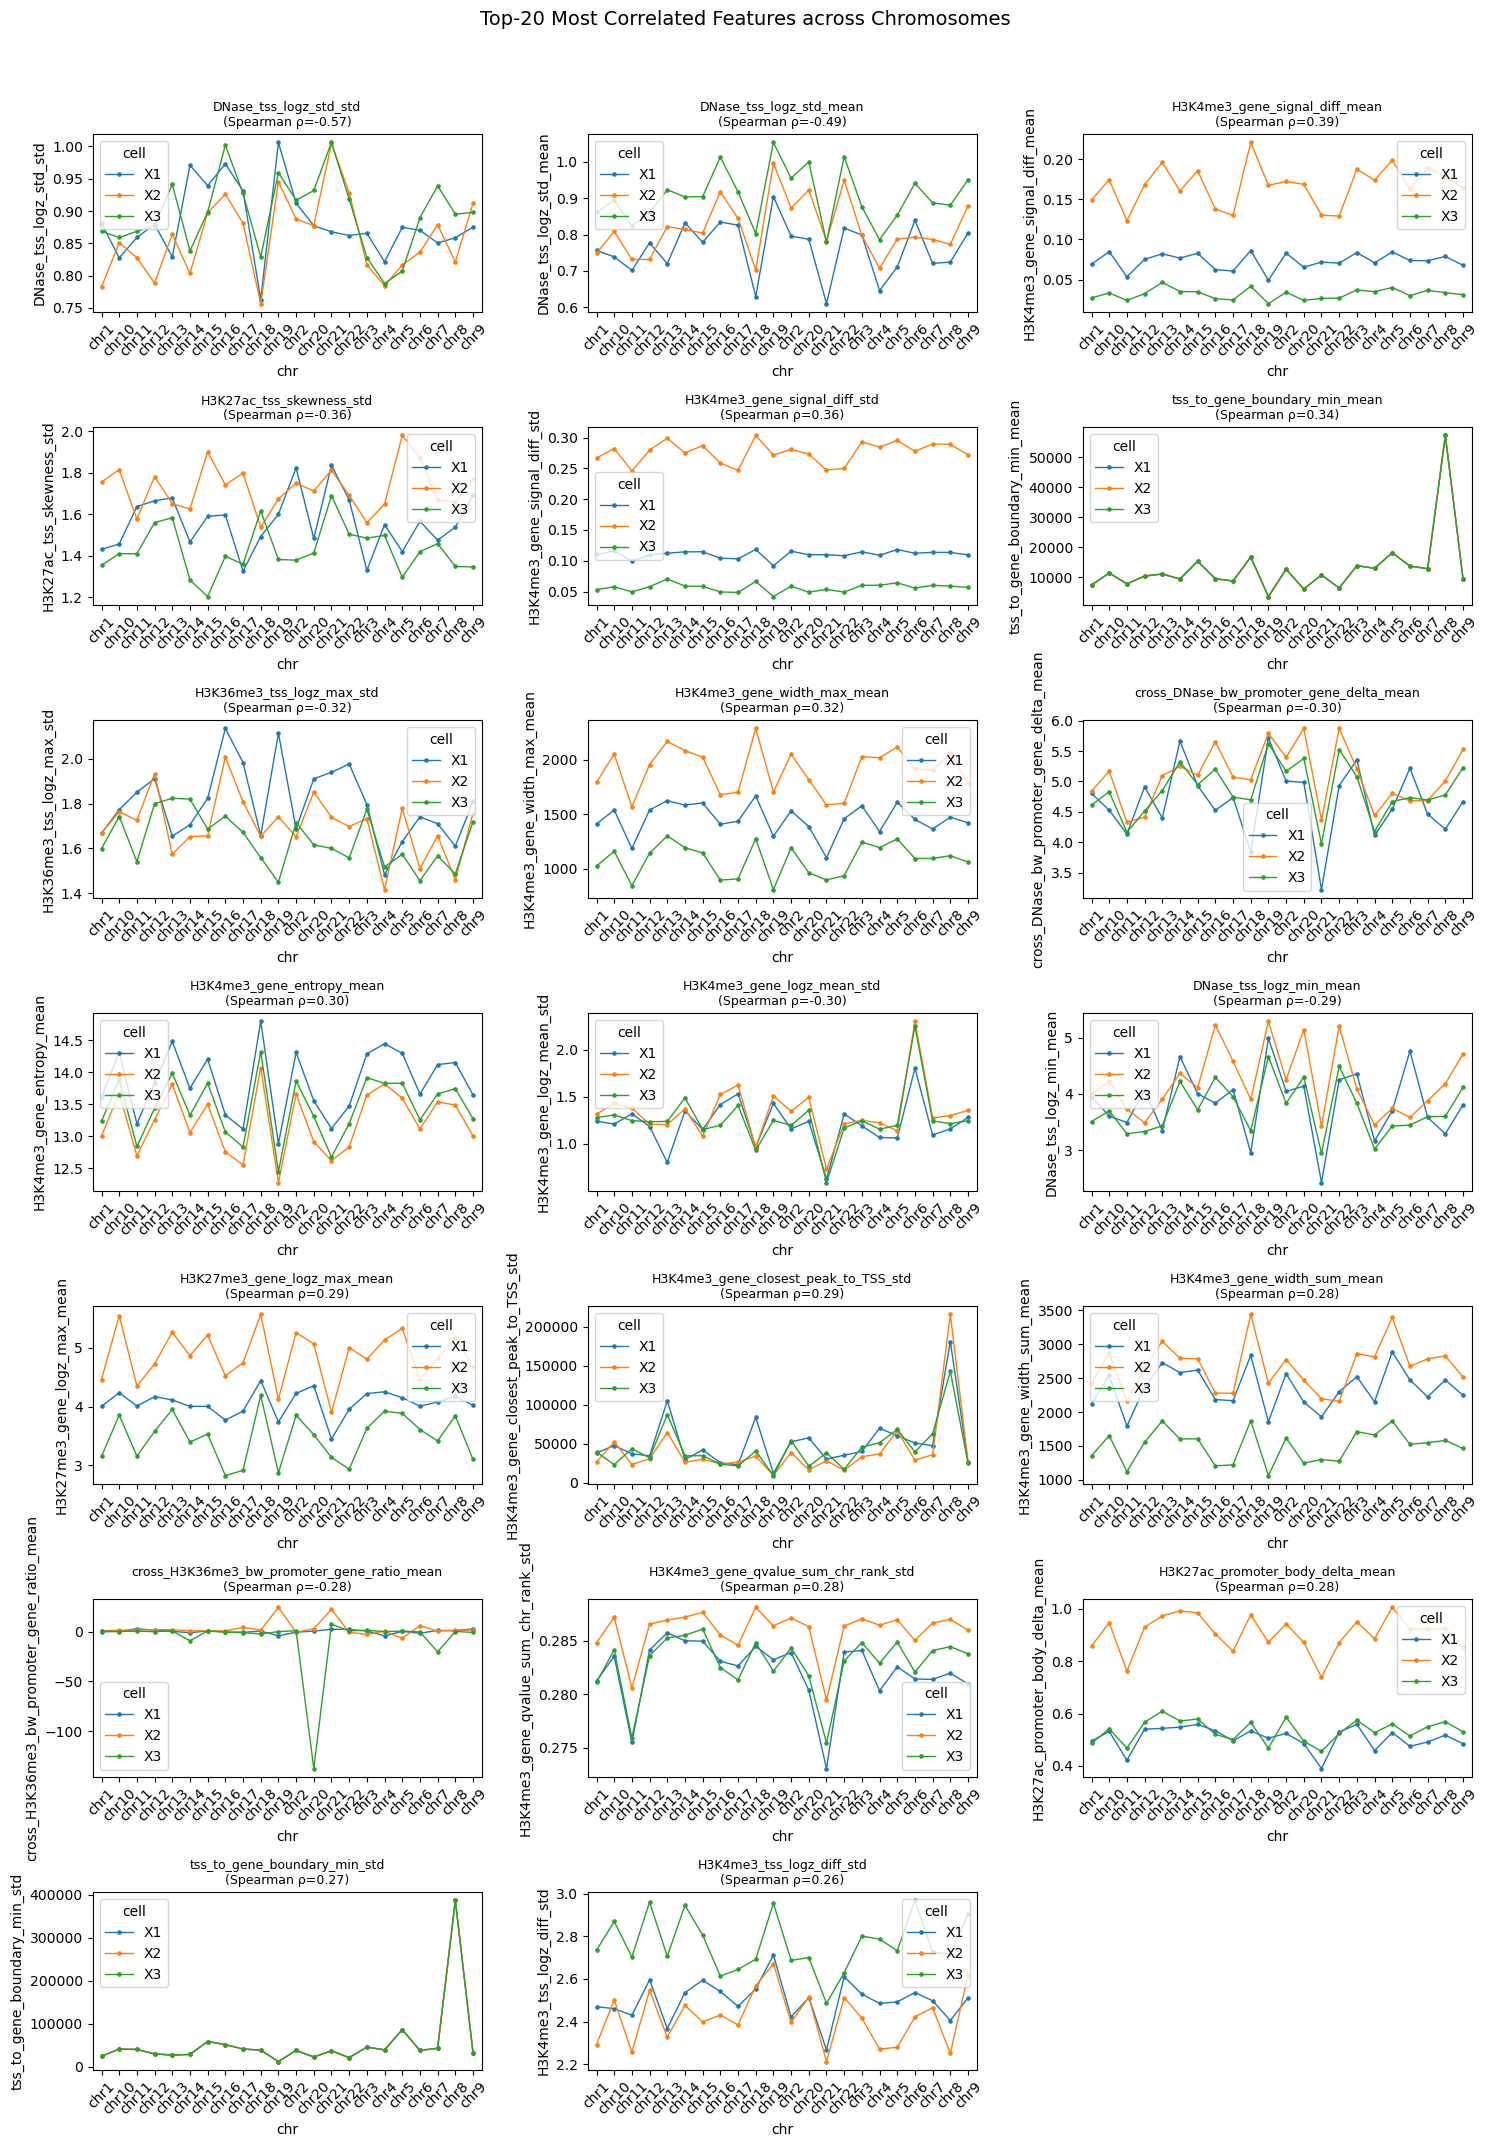

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# === 取出 Top 20 特徵名稱 ===
top_features = corr_df.index.tolist()

# === 依序繪圖 ===
ncols = 3  # 每行幾張
nrows = int(np.ceil(len(top_features) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3))
axes = axes.flatten()

for i, feat in enumerate(top_features):
    if feat not in df_chr_cell.columns:
        print(f"⚠️ Skip missing feature: {feat}")
        continue
    sns.pointplot(
        data=df_chr_cell,
        x="chr", y=feat, hue="cell", ax=axes[i],
        errorbar=None,  # 不顯示誤差條
        markers="o", linewidth=1
    )
    axes[i].set_title(f"{feat}\n(Spearman ρ={corr_df.loc[feat, 'spearman_corr']:.2f})", fontsize=9)
    axes[i].tick_params(axis='x', rotation=45)

# 移除多餘空白子圖
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Top-20 Most Correlated Features across Chromosomes", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()
